# 수치형변수 처리

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from warnings import simplefilter

In [2]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('ggplot')
simplefilter('ignore')

## 학습데이터 로드

학습데이터는 데이콘 [영화 관객수 예측 모델 개발](https://dacon.io/competitions/open/235536/data/) 페이지에서 다운로드하여 `../data/movies/` 폴더에 저장해 둔다.

이 데이터는 영화의 장르, 개봉일, 상영시간 등과 같은 데이터로 영화 총 관객수 (`box_off_num`)를 예측하는 데이터이다.

In [5]:
data_dir = Path('')
trn_file = data_dir / 'movies_train.csv'
seed = 42

In [6]:
df = pd.read_csv(trn_file, index_col=0)
print(df.shape)
df.head()

(600, 11)


,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
title,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


## EDA (Exploratory Data Analysis)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  270 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


독립변수를 포함 총 6개의 수치형변수가 있다. 그 중 `dir_prev_bfnum`은 결측값이 많음을 확인할 수 있다.

In [9]:
df.fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  600 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


결측값을 0으로 대체하였다.

In [10]:
df.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


수치형변수의 분포로부터 모든 수치형변수가 0이나 양수의 값을 가짐을 알 수 있다.

In [11]:
target_col = 'box_off_num'
pred_col = 'pred'

# 수치형 변수들의 모임
num_cols = [x for x in df.columns if df[x].dtype in [np.int64, np.float64] and x != target_col]
print(num_cols)

['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']


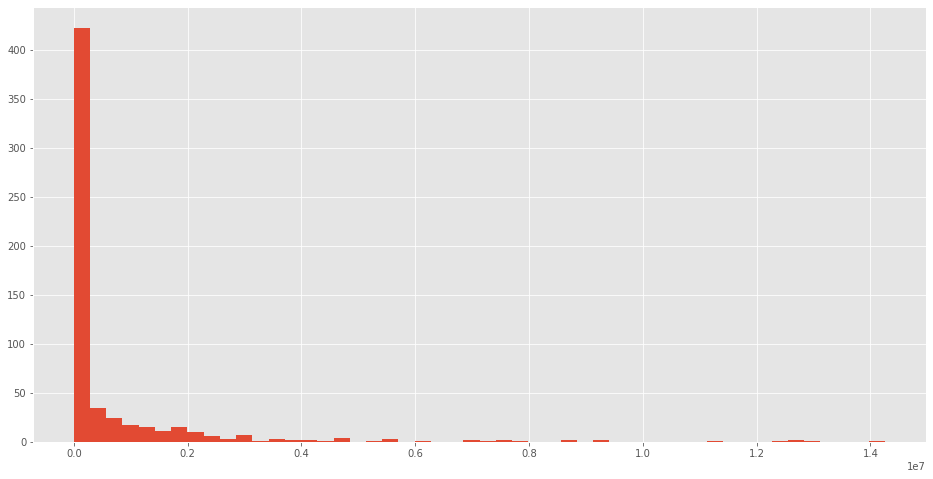

In [12]:
df.box_off_num.hist(bins=50)

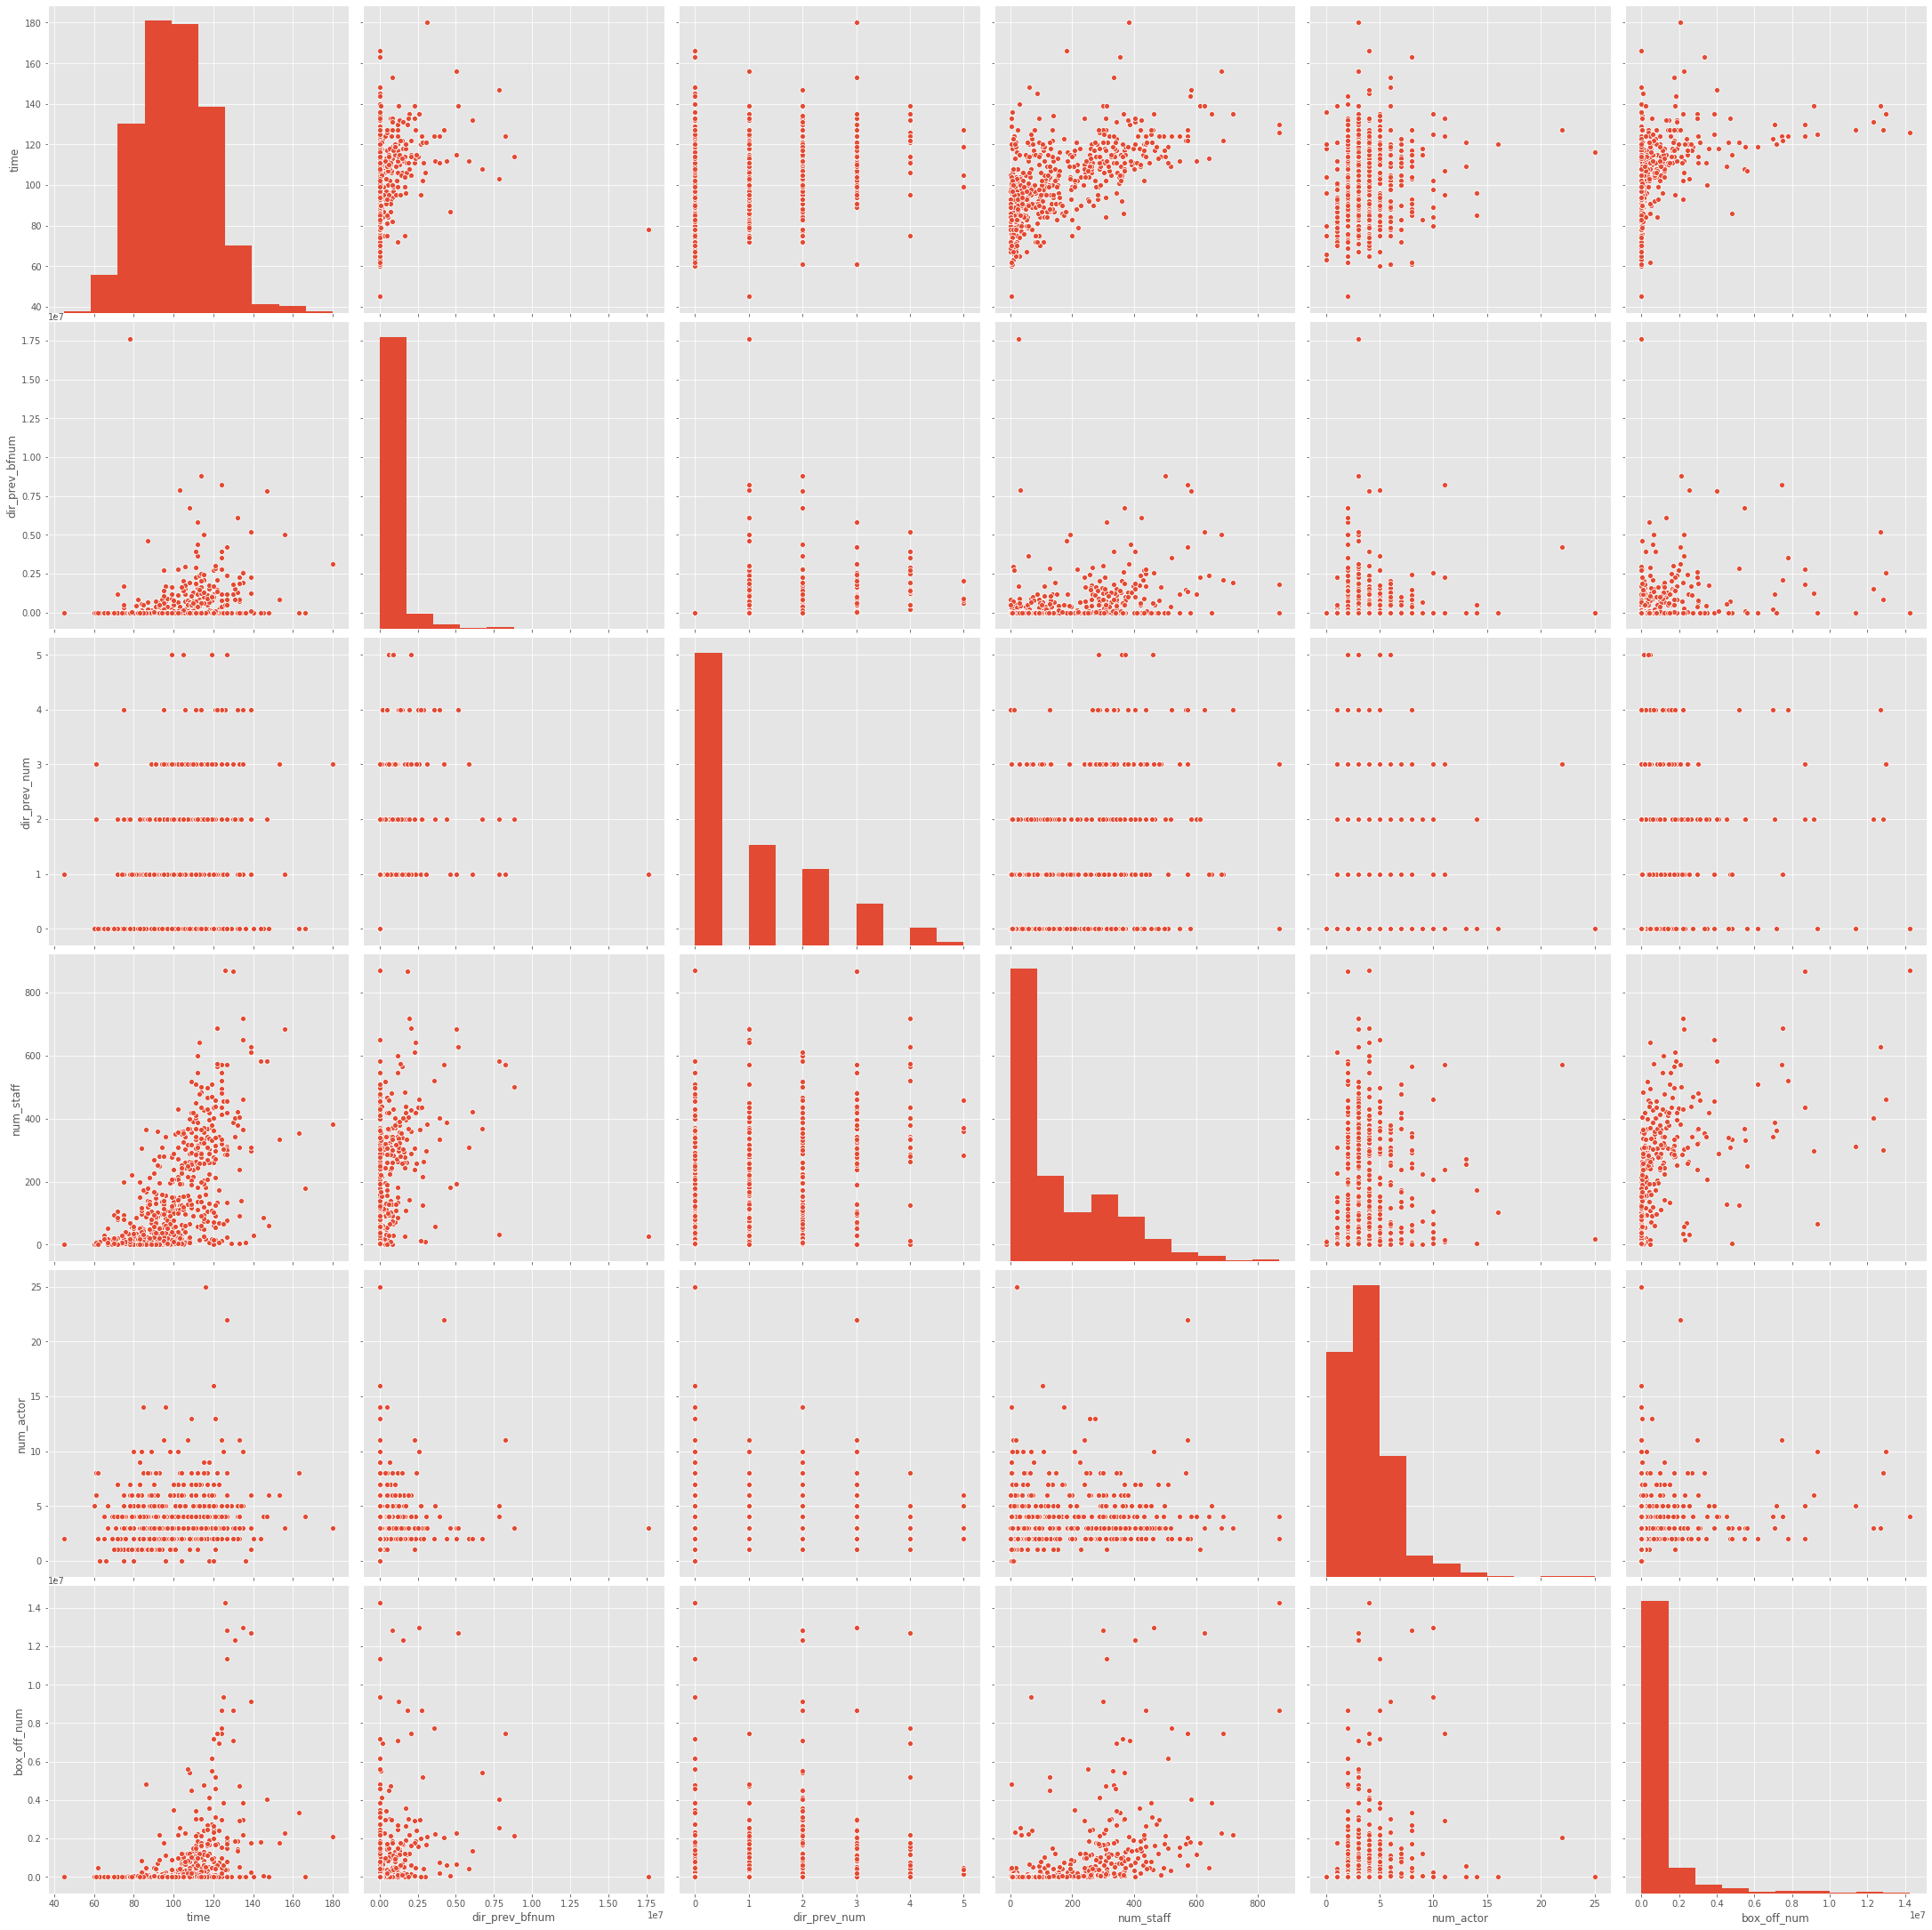

In [13]:
sns.pairplot(data=df, vars=num_cols + [target_col], size=5)

수치형변수 중 `time`은 정규분포에 가깝고 나머지는 멱함수 (power-law)분포에 가깝다.

In [14]:
# 상관관계
df.corr().style.background_gradient()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000


## 선형회귀 모델 학습

### RMSE/RMLSE 손실함수 정의

In [15]:
rmse = lambda y, p: np.sqrt(mean_squared_error(y, p))
rmlse = lambda y, p: np.sqrt(mean_squared_error(np.log1p(y), np.log1p(p)))

### 변수 가공없이 선형회귀 모델 학습

In [16]:
lr = LinearRegression()
lr.fit(df[num_cols], df[target_col])
df[pred_col] = lr.predict(df[num_cols])

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1500066.43


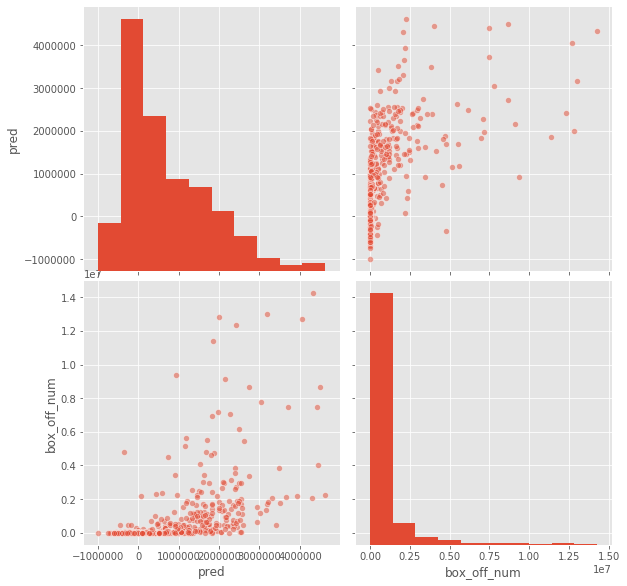

In [17]:
sns.pairplot(data=df, vars=[pred_col, target_col], size=4, plot_kws={'alpha': .5})

- 예측값 중 음수가 존재하고 큰 값의 예측은 비교적 정확한 반면 적은 값의 예측은 오차가 많이 발생하였다.
- 선형의 관계가 보여야 예측값과 실제값이 매우 비슷하다고 할 수 있으나 위는 데이터에 아무런 조치를 취해주지 않았기에 많이 다른것을 알 수 있다.

### 멱함수 분포 변수 `log1p` 변환

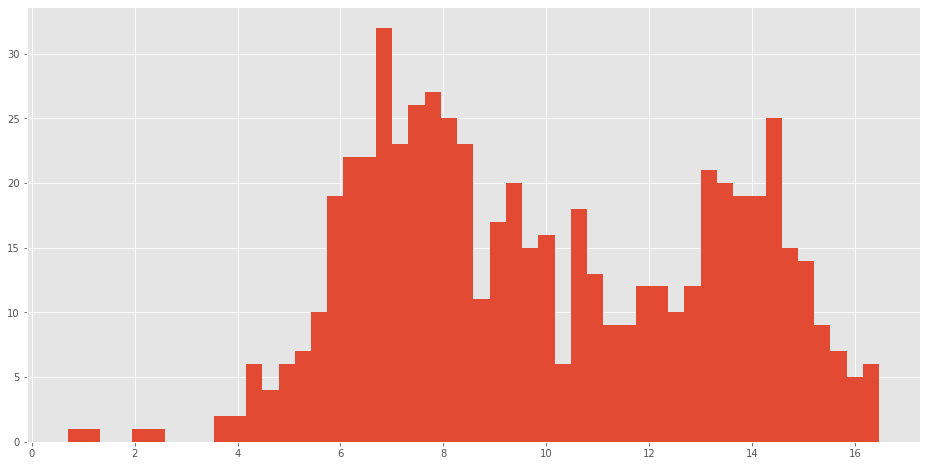

In [18]:
df.box_off_num.apply(np.log1p).hist(bins=50)

- 멱함수 분포의 수치형 변수는 `np.log1p()` 함수로 정규분포에 가깝게 변환할 수 있다. 역변환은 `np.expm1()` 함수를 이용하면 된다.
- 수치형 변수가 멱함수 분포일때 가장 많이 사용되는 방법이다.
- 그냥 log는 log(0)이 정의가 되지 않기에 실제값에 1을 더해서 log를 취해준다. 이렇게 하면 가장 낮은 값이 0이 된다.
- 피처 엔지니어링 후 원래대로 돌려주어야 하기에 역변환을 해야 한다. : 결과변수의 경우

In [19]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	 17129211.69
RMLSE:	        2.12


- RMSE : log로 변환을 하게 되면 가장 큰 값들에 대해서 error를 적용

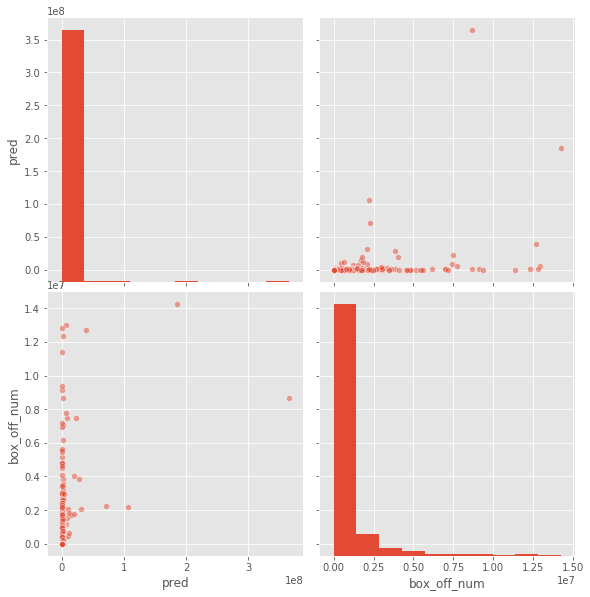

In [20]:
sns.pairplot(data=df, vars=[pred_col, target_col], size=4, plot_kws={'alpha': .5})

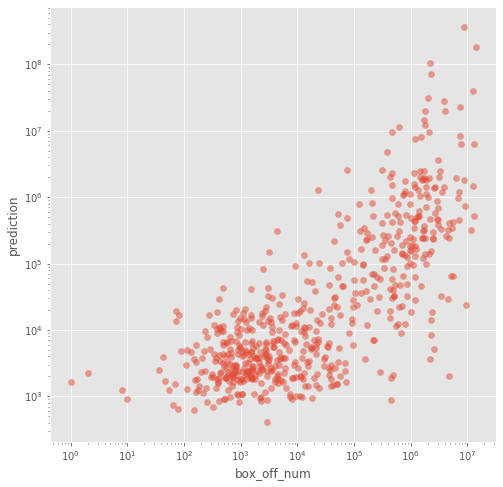

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

In [23]:
df[['dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = df[['dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']].apply(np.log1p)
df[num_cols].describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,100.863333,5.305796,0.462197,4.026352,1.446130
std,18.097528,6.254561,0.555570,1.789517,0.446256
min,45.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,0.000000,0.000000,2.890372,1.098612
50%,100.000000,0.000000,0.000000,4.424829,1.386294
75%,114.000000,12.837611,1.098612,5.579730,1.609438
max,180.000000,16.684279,1.791759,6.768493,3.258097


수치형 독립변수 중 멱변환 분포를 따르는 변수에도 `np.log1p()` 변환을 적용하였다.

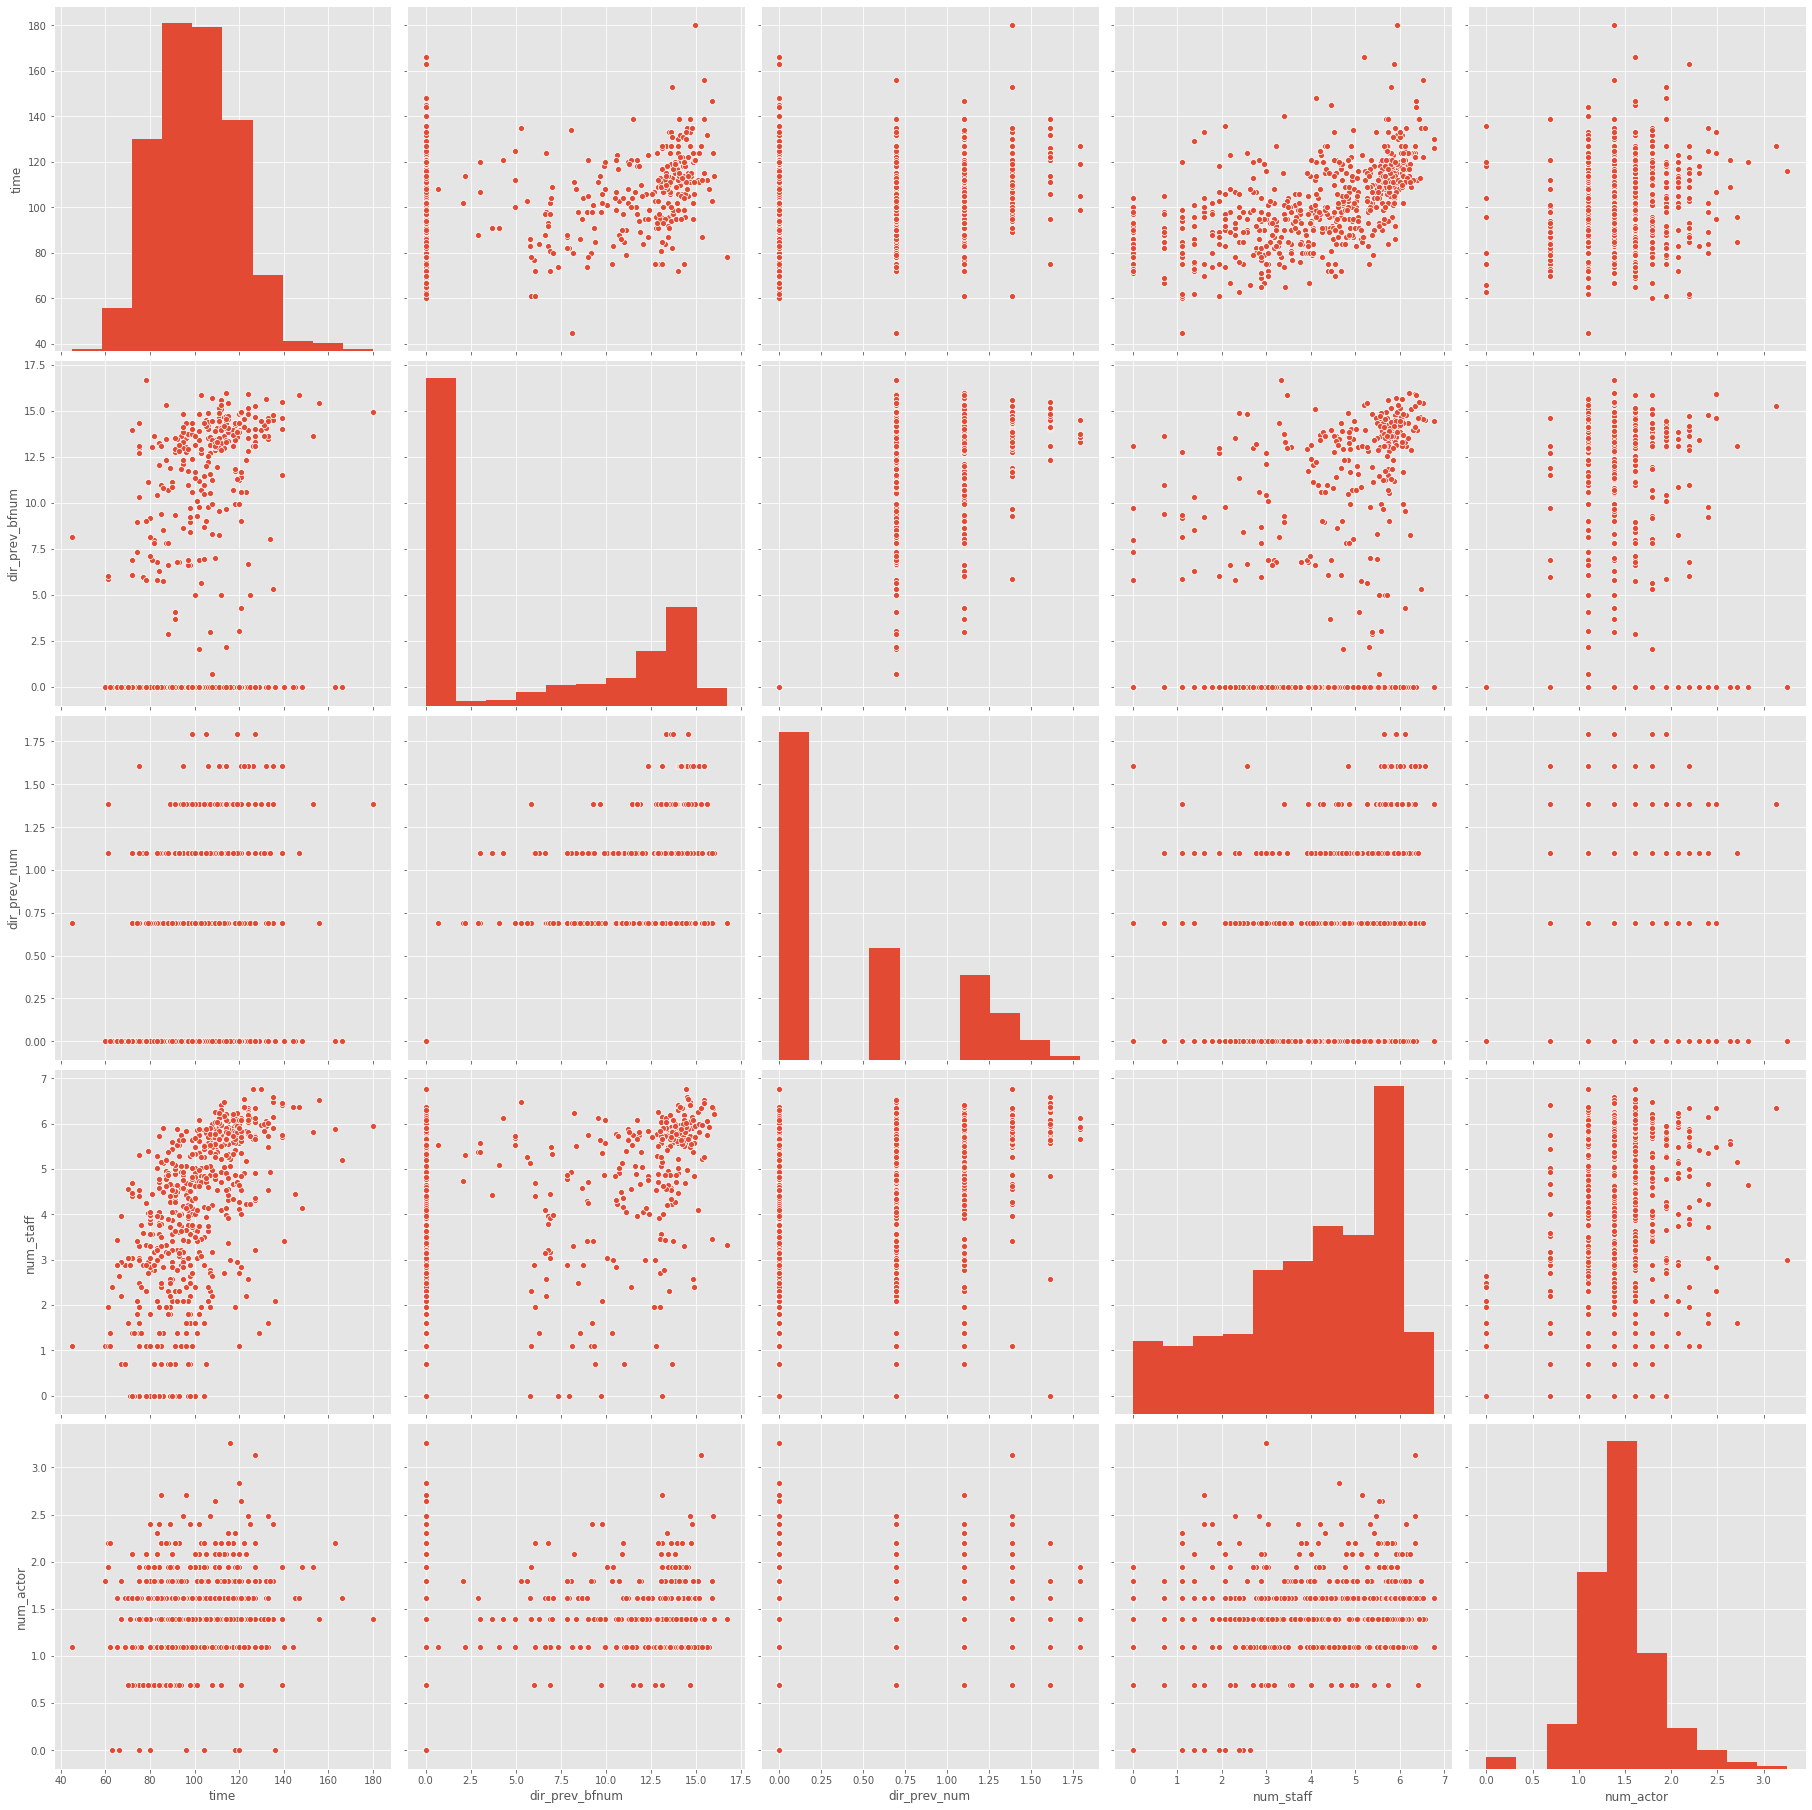

In [24]:
sns.pairplot(data=df, vars=num_cols, size=5)

In [25]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1883568.88
RMLSE:	        2.32


RMLSE는 조금 나빠졌지만 RMSE는 크게 개선이 되었다.

In [26]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1883568.88
RMLSE:	        2.32


- 날짜 변수를 만든뒤 적용했더니 RMSE가 줄었다.

## 정규화/스케일링
- 선형회귀나 결정트리에서는 스케일링이 중요하지 않다.
- 신경망에서는 매우 중요.
- 비선형 알고리즘에서는 일반적으로 도움이 된다.

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1883568.88
RMLSE:	        2.32


In [29]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1883568.88
RMLSE:	        2.32


In [30]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1883568.88
RMLSE:	        2.32


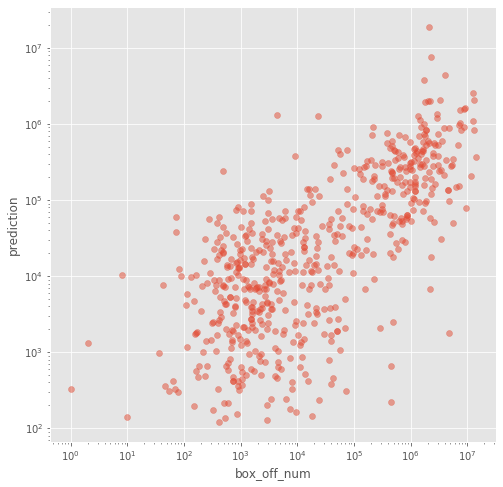

In [31]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

## 2차 다항회귀 (Polynomial Regression)
- 변수가 2개가 있을때 두개의 수치형 변수를 사용하여 여러개의 파생 변수를 생성하는 것.
- PolynomialFeatures 함수를 통해 적용
- 과적합의 위험이 있기에 조심해서 사용. 특히 데이터 개수가 적을때는 더욱 조심해야 한다.
- 2차 이상의 다항회귀 변환은 추천하지 않는다.

In [32]:
from sklearn.preprocessing import PolynomialFeatures

In [33]:
# 2차 다항회귀 변환 시도
poly = PolynomialFeatures(2)
X = poly.fit_transform(df[num_cols])
print(X.shape)

# 변수명은 나오질 않는다.
print(X)

(600, 21)
[[  1.          96.           0.         ...  20.44657194   4.9676925
    1.20694896]
 [  1.         130.          13.96531194 ...  35.53358466   8.26370809
    1.92181206]
 [  1.         123.          12.30490502 ...  34.11309497   9.40015012
    2.59029039]
 ...
 [  1.          99.           0.         ...  23.23511437   7.7579439
    2.59029039]
 [  1.         102.           0.         ...  36.82578912   9.76675421
    2.59029039]
 [  1.         120.           0.         ...  34.77642374  10.56628128
    3.210402  ]]


In [34]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  2500125.53
RMLSE:	        2.03


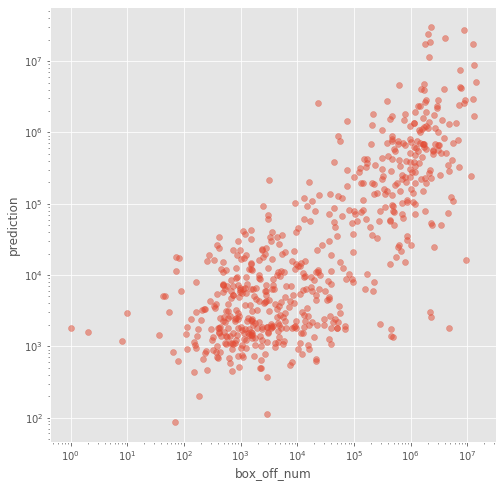

In [35]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')